In [2]:
%run -m ipy_startup
%matplotlib inline
import tensorflow as tf

In [49]:
# # Regression Data
# n_vars = 2
# n_samples = 1000
# drop_pct = .5
# w = np.random.randn(n_vars)
# X = np.random.randn(n_samples, n_vars)
# y = np.hstack((np.multiply(X, w), np.random.randn(n_samples, 1)))

# y = np.sum(y, axis=1)
# idx = np.random.choice(np.arange(len(y)), replace=True, size=int(len(y) * drop_pct))
# y[idx] = np.nan

In [ ]:
# Classification Data
n_vars = 2
n_samples = 1000
drop_pct = .5

In [51]:
def predict(X, W, b, y, n_samples):
    y_pred = tf.reshape(tf.add(tf.matmul(X, W), b), [-1])
    y_fill = tf.select(tf.is_nan(y), y_pred, y)
    loss = tf.reduce_sum(tf.pow(y_fill - y_pred, 2)) / n_samples
    return W, b, y_pred, y_fill, loss

# def predict(X, W, b, y, n_samples):
#     y_pred = tf.reshape(tf.add(tf.matmul(X, W), b), [-1])
#     loss = tf.reduce_sum(tf.pow(y - y_pred, 2)) / n_samples
#     y_fill = None
#     return W, b, y_pred, y_fill, loss

def get_model(n_samples, n_vars):
    Xi = tf.placeholder(tf.float32, shape=[n_samples, n_vars])
    yi = tf.placeholder(tf.float32, shape=[n_samples])
    
    W = tf.Variable(tf.zeros([2,1]), name="weights")
    b = tf.Variable(tf.zeros([1]), name="bias")
    #b = tf.Variable(np.random.randn(), name='bias')
    
    W, b, y_pred, y_fill, loss = predict(Xi, W, b, yi, n_samples)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=.01).minimize(loss)
    return W, b, Xi, yi, y_pred, y_fill, optimizer, loss

In [52]:
tf.reset_default_graph()
W, b, Xi, yi, y_pred, y_fill, optimizer, loss = get_model(n_samples, n_vars)

In [53]:

init = tf.initialize_all_variables()
yp = None
with tf.Session() as sess:
    sess.run(init)
    for i in range(100):
        #print(sess.run(y_fill, feed_dict={Xi:X, yi:y}))
        sess.run(optimizer, feed_dict={Xi:X, yi:y})
        if i % 10 == 0:
            c = sess.run(loss, feed_dict={Xi:X, yi:y})
            print('Iteration {}: Cost = {}'.format(i + 1, c))
    yp = sess.run(y_pred, feed_dict={Xi:X, yi:y})   

Iteration 1: Cost = 1.1217153072357178
Iteration 11: Cost = 1.014649510383606
Iteration 21: Cost = 0.9278941750526428
Iteration 31: Cost = 0.8575946092605591
Iteration 41: Cost = 0.8006275296211243
Iteration 51: Cost = 0.7544631958007812
Iteration 61: Cost = 0.7170517444610596
Iteration 71: Cost = 0.6867326498031616
Iteration 81: Cost = 0.6621610522270203
Iteration 91: Cost = 0.6422466039657593


In [54]:
d = pd.DataFrame(np.hstack([X, np.reshape(y, (-1, 1))])).add_prefix('X')
d = d.rename(columns={d.columns[-1]:'y'})
d['y_pred'] = yp
d.head()

,X0,X1,y,y_pred
0,0.426084,0.521041,0.906908,-0.348892
1,0.202492,1.816305,NaN,-0.411890
2,-2.300508,-0.231246,NaN,1.581662
3,-0.635307,-0.065465,1.945041,0.450516
4,-0.406291,-0.029994,1.305311,0.292883


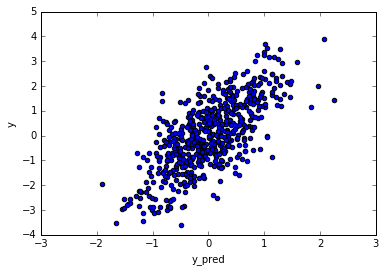

In [55]:
d.plot(kind='scatter', x='y_pred', y='y')

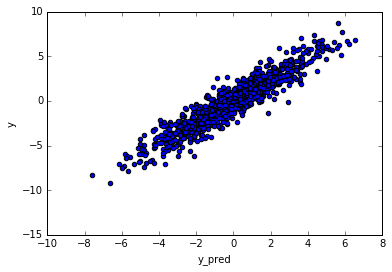

In [47]:
d.plot(kind='scatter', x='y_pred', y='y')

# TF Learn

In [108]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
X, y = make_classification(
    n_samples=1000, n_informative=2, n_classes=3, n_redundant=0, 
    n_features=10, n_clusters_per_class=1, class_sep=10, 
    random_state=123
)
X = pd.DataFrame(StandardScaler().fit_transform(X)).add_prefix('X')
y = pd.Series(y)
#clf = RandomForestClassifier().fit(X, y)
clf = GradientBoostingClassifier().fit(X, y)
X.shape, y.shape

((1000, 10), (1000,))

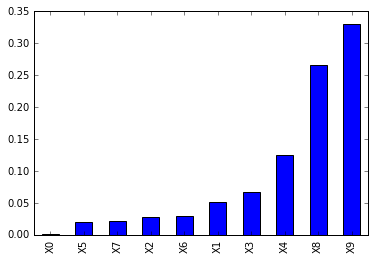

In [82]:
pd.Series(clf.feature_importances_, index=X.columns).sort_values().plot(kind='bar')

In [162]:
pd.DataFrame({'predicted':clf.predict(X), 'actual': y.values}).groupby(['predicted', 'actual']).size().unstack()

actual,0,1,2
predicted,,,
0,332.0,NaN,NaN
1,NaN,333.0,NaN
2,NaN,NaN,335.0


In [97]:
def tfeval(exp):
    sess = tf.InteractiveSession()
    res = sess.run(exp)
    sess.close()
    return res

In [106]:
x = tf.constant([[1.,2], [3,4]])
v = x * x
v = tf.sqrt(tf.reduce_sum(v, 1, keep_dims=False))
tfeval(y)

array([ 2.23606801,  5.        ], dtype=float32)

In [233]:
import tensorflow.contrib.learn.python.learn as learn
from sklearn import metrics

def my_model(X, y, mode, params):
    print(params)
    a1=params['a1']
    a2=params['a2']
    a3=params['a3']
    yt = tf.one_hot(y, 3)
    
    b1 = tf.Variable(tf.zeros([3]), name='b1')

    W1 = tf.Variable(tf.random_normal([5, 3]), name='W1')
    W2 = tf.Variable(tf.random_normal([5, 3]), name='W2')
    
    h1 = tf.matmul(X[:,0:5], W1)
    h2 = tf.matmul(X[:,5:10], W2)
    
    w1 = tf.Variable(tf.zeros([3]))
    w2 = tf.Variable(tf.zeros([3]))
    h3 = tf.add(tf.mul(h1, w1), tf.mul(h2, w2)) + b1
    yp = tf.nn.softmax(h3)
    
    loss_y = tf.reduce_mean(-tf.reduce_sum(yt * tf.log(yp), reduction_indices=[1]), name='loss_y')
    
    
    loss_W1_min = -tf.minimum(tf.reduce_min(W1), 0, name='loss_W1_min')
    loss_W1_reg = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.pow(W1, 2), 1, keep_dims=True)), name='loss_W1_reg')
    loss_W1 = tf.mul(a1, tf.add(loss_W1_min, loss_W1_reg), name='loss_W1')

    loss_W2_min = -tf.minimum(tf.reduce_min(W2), 0, name='loss_W2_min')
    loss_W2_reg = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.pow(W2, 2), 1, keep_dims=True)), name='loss_W2_reg')
    loss_W2 = tf.mul(a2, tf.add(loss_W2_min, loss_W2_reg), name='loss_W2')
    
    loss_w = tf.mul(a3, tf.reduce_sum(tf.abs(tf.concat(0, [w1, w2]))), name='loss_w')

    loss = tf.identity(loss_y + loss_W1 + loss_W2 + loss_w, name='loss')
    
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.contrib.framework.get_global_step(), optimizer='Adagrad',
        learning_rate=0.1)
    return yp, loss, train_op

In [232]:
tf.logging.set_verbosity(tf.logging.INFO)
classifier = learn.Estimator(model_fn=my_model, params=dict(a1=.01, a2=.01, a3=.01))
monitor_loss = learn.monitors.CaptureVariable('loss', every_n=1)
monitors = [
    learn.monitors.PrintTensor(['loss_y', 'loss_W1', 'loss_W2', 'loss_w']),
    learn.monitors.ValidationMonitor(X.values, y.values, early_stopping_rounds=50),
    monitor_loss
]
classifier.fit(X.values, y.values, max_steps=1000, monitors=monitors)
#score = metrics.accuracy_score(y.values, classifier.predict(X.values))
#print("Accuracy: %f" % score)

{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Step 1: loss_y = 1.09861, loss_W2 = 0.0929058, loss_w = 0.0, loss_W1 = 0.106699
INFO:tensorflow:Step 1: loss = 1.29822
INFO:tensorflow:Saving checkpoints for 60 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpe0axladb/model.ckpt.


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


KeyboardInterrupt: 

In [218]:
from sklearn.base import ClassifierMixin
??learn.Estimator

In [254]:
from sklearn.base import BaseEstimator, ClassifierMixin

class LearnClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, model_fn, model_params=None, model_config=None):
        self.model_fn = model_fn
        self.model_params = model_params
        self.model_config = model_config
    
    def fit(self, X, y, **kwargs):
        assert 'monitors' not in kwargs, \
            'Monitors should not be passed directly to the fit function, '\
            'instead a monitor_fn argument should be supplied that takes '\
            'as input the X and y values to fit on and returns a map of '\
            'monitors keyed by name for later reference'
        self.monitors_ = None
        if 'monitor_fn' in kwargs:
            self.monitors_ = kwargs['monitor_fn'](X, y)
            assert isinstance(self.monitors_, dict), 'Monitor map must be a dictionary'
            del kwargs['monitor_fn']
        self.classifier_ = learn.Estimator(model_fn=self.model_fn, params=self.model_params, config=self.model_config)
        self.classifier_.fit(X, y, monitors=list(self.monitors_.values()), **kwargs)
        return self
    
    def predict(self, X):
        return np.argmax(self.classifier_.predict(X), axis=1)
    
    def predict_proba(self, X):
        return self.classifier_.predict(X)

In [264]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
#clfx.set_params(params=dict(a1=.01, a2=.01, a3=.02))
grid = {
    'model_fn': [my_model],
    'model_params': [dict(a1=.01, a2=.01, a3=.02), dict(a1=.01, a2=.01, a3=.01)]
}

def monitor_fn(X, y):
    return {
        'print': learn.monitors.PrintTensor(['loss_y', 'loss_W1', 'loss_W2', 'loss_w']),
        'validate': learn.monitors.ValidationMonitor(X, y, early_stopping_rounds=10),
        'loss': learn.monitors.CaptureVariable('loss', every_n=1)
    }

clf = LearnClassifier(
    model_fn=my_model, 
    model_params=dict(a1=.01, a2=.01, a3=.01),
    model_config=learn.run_config.RunConfig(save_checkpoints_secs=100)
)
clf_grid = GridSearchCV(clf, grid, cv=2, fit_params=dict(max_steps=1000, monitor_fn=monitor_fn))
clf_grid = clf_grid.fit(X.values, y.values)
#clfx.get_params()

{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Step 1: loss_y = 1.09861, loss_W2 = 0.0929058, loss_w = 0.0, loss_W1 = 0.106699
INFO:tensorflow:Step 1: loss = 1.29822
INFO:tensorflow:Skipping evaluation since model has not been saved yet at step 100.
INFO:tensorflow:Saving checkpoints for 100 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt.
INFO:tensorflow:Step 101: loss_y = 0.186799, loss_W2 = 0.0836254, loss_w = 0.0488194, loss_W1 = 0.0827462
INFO:tensorflow:Step 101: loss = 0.40199


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt-100-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 100.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 100 step: loss = 0.40199
INFO:tensorflow:Validation (step 200): global_step = 100, loss = 0.40199
INFO:tensorflow:Saving checkpoints for 200 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt.
INFO:tensorflow:Step 201: loss_y = 0.0521592, loss_W2 = 0.077847, loss_w = 0.0643389, loss_W1 = 0.0620415
INFO:tensorflow:Step 201: loss = 0.256387


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt-200-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 200.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 200 step: loss = 0.256387
INFO:tensorflow:Validation (step 300): global_step = 200, loss = 0.256387
INFO:tensorflow:Saving checkpoints for 300 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt.
INFO:tensorflow:Step 301: loss_y = 0.0362472, loss_W2 = 0.0724959, loss_w = 0.0690335, loss_W1 = 0.0455563
INFO:tensorflow:Step 301: loss = 0.223333


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt-300-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 300.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 300 step: loss = 0.223333
INFO:tensorflow:Validation (step 400): global_step = 300, loss = 0.223333
INFO:tensorflow:Saving checkpoints for 400 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt.
INFO:tensorflow:Step 401: loss_y = 0.0310968, loss_W2 = 0.0706063, loss_w = 0.0710914, loss_W1 = 0.0301329
INFO:tensorflow:Step 401: loss = 0.202927


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt-400-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 400.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 400 step: loss = 0.202927
INFO:tensorflow:Validation (step 500): global_step = 400, loss = 0.202927
INFO:tensorflow:Saving checkpoints for 500 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt.
INFO:tensorflow:Step 501: loss_y = 0.0287554, loss_W2 = 0.0688061, loss_w = 0.0720146, loss_W1 = 0.0159913
INFO:tensorflow:Step 501: loss = 0.185567


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt-500-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 500.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 500 step: loss = 0.185567
INFO:tensorflow:Validation (step 600): global_step = 500, loss = 0.185567
INFO:tensorflow:Saving checkpoints for 600 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt.
INFO:tensorflow:Step 601: loss_y = 0.0275603, loss_W2 = 0.0674068, loss_w = 0.0724571, loss_W1 = 0.00544417
INFO:tensorflow:Step 601: loss = 0.172868


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt-600-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 600.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 600 step: loss = 0.172868
INFO:tensorflow:Validation (step 700): global_step = 600, loss = 0.172868
INFO:tensorflow:Saving checkpoints for 700 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt.
INFO:tensorflow:Step 701: loss_y = 0.0268598, loss_W2 = 0.0677462, loss_w = 0.0726649, loss_W1 = 0.0018138
INFO:tensorflow:Step 701: loss = 0.169085


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt-700-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 700.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 700 step: loss = 0.169085
INFO:tensorflow:Validation (step 800): global_step = 700, loss = 0.169085
INFO:tensorflow:Saving checkpoints for 800 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt.
INFO:tensorflow:Step 801: loss_y = 0.0264448, loss_W2 = 0.0679971, loss_w = 0.0727322, loss_W1 = 9.58395e-05
INFO:tensorflow:Step 801: loss = 0.16727


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt-800-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 800.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 800 step: loss = 0.16727
INFO:tensorflow:Validation (step 900): global_step = 800, loss = 0.16727
INFO:tensorflow:Saving checkpoints for 900 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt.
INFO:tensorflow:Step 901: loss_y = 0.0261946, loss_W2 = 0.0682122, loss_w = 0.0727085, loss_W1 = 9.90003e-05
INFO:tensorflow:Step 901: loss = 0.167214


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt-900-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 900.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 900 step: loss = 0.167214
INFO:tensorflow:Validation (step 1000): global_step = 900, loss = 0.167214
INFO:tensorflow:Saving checkpoints for 1000 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt.
INFO:tensorflow:Loss for final step: 0.167154.


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Loading model from checkpoint: /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5jfoseon/model.ckpt-1000-?????-of-00001.


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Step 1: loss_y = 1.09861, loss_W2 = 0.0929058, loss_w = 0.0, loss_W1 = 0.106699
INFO:tensorflow:Step 1: loss = 1.29822
INFO:tensorflow:Skipping evaluation since model has not been saved yet at step 100.
INFO:tensorflow:Saving checkpoints for 100 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt.
INFO:tensorflow:Step 101: loss_y = 0.154931, loss_W2 = 0.0863789, loss_w = 0.0602108, loss_W1 = 0.0829347
INFO:tensorflow:Step 101: loss = 0.384455


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt-100-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 100.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 100 step: loss = 0.384455
INFO:tensorflow:Validation (step 200): global_step = 100, loss = 0.384455
INFO:tensorflow:Saving checkpoints for 200 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt.
INFO:tensorflow:Step 201: loss_y = 0.0708982, loss_W2 = 0.0830026, loss_w = 0.0728317, loss_W1 = 0.0621805
INFO:tensorflow:Step 201: loss = 0.288913


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt-200-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 200.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 200 step: loss = 0.288913
INFO:tensorflow:Validation (step 300): global_step = 200, loss = 0.288913
INFO:tensorflow:Saving checkpoints for 300 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt.
INFO:tensorflow:Step 301: loss_y = 0.0621483, loss_W2 = 0.0777881, loss_w = 0.0735227, loss_W1 = 0.0456666
INFO:tensorflow:Step 301: loss = 0.259126


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt-300-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 300.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 300 step: loss = 0.259126
INFO:tensorflow:Validation (step 400): global_step = 300, loss = 0.259126
INFO:tensorflow:Saving checkpoints for 400 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt.
INFO:tensorflow:Step 401: loss_y = 0.0590147, loss_W2 = 0.0726249, loss_w = 0.0734177, loss_W1 = 0.0302387
INFO:tensorflow:Step 401: loss = 0.235296


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt-400-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 400.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 400 step: loss = 0.235296
INFO:tensorflow:Validation (step 500): global_step = 400, loss = 0.235296
INFO:tensorflow:Saving checkpoints for 500 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt.
INFO:tensorflow:Step 501: loss_y = 0.0581819, loss_W2 = 0.0681811, loss_w = 0.0730158, loss_W1 = 0.016074
INFO:tensorflow:Step 501: loss = 0.215453


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt-500-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 500.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 500 step: loss = 0.215453
INFO:tensorflow:Validation (step 600): global_step = 500, loss = 0.215453
INFO:tensorflow:Saving checkpoints for 600 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt.
INFO:tensorflow:Step 601: loss_y = 0.0583899, loss_W2 = 0.0656757, loss_w = 0.072506, loss_W1 = 0.00549526
INFO:tensorflow:Step 601: loss = 0.202067


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt-600-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 600.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 600 step: loss = 0.202067
INFO:tensorflow:Validation (step 700): global_step = 600, loss = 0.202067
INFO:tensorflow:Saving checkpoints for 700 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt.
INFO:tensorflow:Step 701: loss_y = 0.058386, loss_W2 = 0.0651769, loss_w = 0.072095, loss_W1 = 0.00183956
INFO:tensorflow:Step 701: loss = 0.197498


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt-700-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 700.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 700 step: loss = 0.197498
INFO:tensorflow:Validation (step 800): global_step = 700, loss = 0.197498
INFO:tensorflow:Saving checkpoints for 800 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt.
INFO:tensorflow:Step 801: loss_y = 0.0582551, loss_W2 = 0.065182, loss_w = 0.0718366, loss_W1 = 8.87818e-05
INFO:tensorflow:Step 801: loss = 0.195363


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt-800-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 800.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 800 step: loss = 0.195363
INFO:tensorflow:Validation (step 900): global_step = 800, loss = 0.195363
INFO:tensorflow:Saving checkpoints for 900 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt.
INFO:tensorflow:Step 901: loss_y = 0.058126, loss_W2 = 0.0652911, loss_w = 0.0715537, loss_W1 = 9.08444e-05
INFO:tensorflow:Step 901: loss = 0.195062


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt-900-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 900.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 900 step: loss = 0.195062
INFO:tensorflow:Validation (step 1000): global_step = 900, loss = 0.195062
INFO:tensorflow:Saving checkpoints for 1000 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt.
INFO:tensorflow:Loss for final step: 0.194708.


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Loading model from checkpoint: /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpprvwit57/model.ckpt-1000-?????-of-00001.


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Step 1: loss_y = 1.09861, loss_W2 = 0.0929058, loss_w = 0.0, loss_W1 = 0.106699
INFO:tensorflow:Step 1: loss = 1.29822
INFO:tensorflow:Skipping evaluation since model has not been saved yet at step 100.
INFO:tensorflow:Saving checkpoints for 100 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt.
INFO:tensorflow:Step 101: loss_y = 0.135454, loss_W2 = 0.0863113, loss_w = 0.0304917, loss_W1 = 0.0827579
INFO:tensorflow:Step 101: loss = 0.335015


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt-100-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 100.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 100 step: loss = 0.335015
INFO:tensorflow:Validation (step 200): global_step = 100, loss = 0.335015
INFO:tensorflow:Saving checkpoints for 200 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt.
INFO:tensorflow:Step 201: loss_y = 0.0344868, loss_W2 = 0.0833674, loss_w = 0.0408676, loss_W1 = 0.0620426
INFO:tensorflow:Step 201: loss = 0.220764


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt-200-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 200.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 200 step: loss = 0.220764
INFO:tensorflow:Validation (step 300): global_step = 200, loss = 0.220764
INFO:tensorflow:Saving checkpoints for 300 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt.
INFO:tensorflow:Step 301: loss_y = 0.0247151, loss_W2 = 0.0767429, loss_w = 0.0439796, loss_W1 = 0.045553
INFO:tensorflow:Step 301: loss = 0.190991


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt-300-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 300.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 300 step: loss = 0.190991
INFO:tensorflow:Validation (step 400): global_step = 300, loss = 0.190991
INFO:tensorflow:Saving checkpoints for 400 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt.
INFO:tensorflow:Step 401: loss_y = 0.0218599, loss_W2 = 0.0694193, loss_w = 0.0455305, loss_W1 = 0.0301319
INFO:tensorflow:Step 401: loss = 0.166942


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt-400-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 400.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 400 step: loss = 0.166942
INFO:tensorflow:Validation (step 500): global_step = 400, loss = 0.166942
INFO:tensorflow:Saving checkpoints for 500 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt.
INFO:tensorflow:Step 501: loss_y = 0.0206325, loss_W2 = 0.0632547, loss_w = 0.0464124, loss_W1 = 0.0159866
INFO:tensorflow:Step 501: loss = 0.146286


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt-500-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 500.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 500 step: loss = 0.146286
INFO:tensorflow:Validation (step 600): global_step = 500, loss = 0.146286
INFO:tensorflow:Saving checkpoints for 600 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt.
INFO:tensorflow:Step 601: loss_y = 0.0200582, loss_W2 = 0.0619944, loss_w = 0.047023, loss_W1 = 0.00544297
INFO:tensorflow:Step 601: loss = 0.134519


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt-600-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 600.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 600 step: loss = 0.134519
INFO:tensorflow:Validation (step 700): global_step = 600, loss = 0.134519
INFO:tensorflow:Saving checkpoints for 700 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt.
INFO:tensorflow:Step 701: loss_y = 0.019759, loss_W2 = 0.0613944, loss_w = 0.0474626, loss_W1 = 0.00179538
INFO:tensorflow:Step 701: loss = 0.130411


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt-700-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 700.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 700 step: loss = 0.130411
INFO:tensorflow:Validation (step 800): global_step = 700, loss = 0.130411
INFO:tensorflow:Saving checkpoints for 800 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt.
INFO:tensorflow:Step 801: loss_y = 0.0195896, loss_W2 = 0.0607975, loss_w = 0.0478414, loss_W1 = 0.000141489
INFO:tensorflow:Step 801: loss = 0.12837


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt-800-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 800.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 800 step: loss = 0.12837
INFO:tensorflow:Validation (step 900): global_step = 800, loss = 0.12837
INFO:tensorflow:Saving checkpoints for 900 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt.
INFO:tensorflow:Step 901: loss_y = 0.0194904, loss_W2 = 0.0601786, loss_w = 0.0481649, loss_W1 = 0.000104947
INFO:tensorflow:Step 901: loss = 0.127939


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt-900-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 900.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 900 step: loss = 0.127939
INFO:tensorflow:Validation (step 1000): global_step = 900, loss = 0.127939
INFO:tensorflow:Saving checkpoints for 1000 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt.
INFO:tensorflow:Loss for final step: 0.127551.
INFO:tensorflow:Loading model from checkpoint: /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp4cbx6z6w/model.ckpt-1000-?????-of-00001.


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Step 1: loss_y = 1.09861, loss_W2 = 0.0929058, loss_w = 0.0, loss_W1 = 0.106699
INFO:tensorflow:Step 1: loss = 1.29822
INFO:tensorflow:Skipping evaluation since model has not been saved yet at step 100.
INFO:tensorflow:Saving checkpoints for 100 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt.
INFO:tensorflow:Step 101: loss_y = 0.132923, loss_W2 = 0.0866929, loss_w = 0.0321284, loss_W1 = 0.0829375
INFO:tensorflow:Step 101: loss = 0.334682


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt-100-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 100.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 100 step: loss = 0.334682
INFO:tensorflow:Validation (step 200): global_step = 100, loss = 0.334682
INFO:tensorflow:Saving checkpoints for 200 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt.
INFO:tensorflow:Step 201: loss_y = 0.0657341, loss_W2 = 0.0824958, loss_w = 0.0387216, loss_W1 = 0.062232
INFO:tensorflow:Step 201: loss = 0.249184


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt-200-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 200.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 200 step: loss = 0.249184
INFO:tensorflow:Validation (step 300): global_step = 200, loss = 0.249184
INFO:tensorflow:Saving checkpoints for 300 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt.
INFO:tensorflow:Step 301: loss_y = 0.0573539, loss_W2 = 0.0762205, loss_w = 0.0404549, loss_W1 = 0.0457252
INFO:tensorflow:Step 301: loss = 0.219755


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt-300-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 300.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 300 step: loss = 0.219755
INFO:tensorflow:Validation (step 400): global_step = 300, loss = 0.219755
INFO:tensorflow:Saving checkpoints for 400 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt.
INFO:tensorflow:Step 401: loss_y = 0.0542026, loss_W2 = 0.0699722, loss_w = 0.0415054, loss_W1 = 0.0302806
INFO:tensorflow:Step 401: loss = 0.195961


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt-400-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 400.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 400 step: loss = 0.195961
INFO:tensorflow:Validation (step 500): global_step = 400, loss = 0.195961
INFO:tensorflow:Saving checkpoints for 500 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt.
INFO:tensorflow:Step 501: loss_y = 0.0532689, loss_W2 = 0.0644621, loss_w = 0.042297, loss_W1 = 0.0161192
INFO:tensorflow:Step 501: loss = 0.176147


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt-500-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 500.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 500 step: loss = 0.176147
INFO:tensorflow:Validation (step 600): global_step = 500, loss = 0.176147
INFO:tensorflow:Saving checkpoints for 600 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt.
INFO:tensorflow:Step 601: loss_y = 0.0535878, loss_W2 = 0.0605517, loss_w = 0.0428272, loss_W1 = 0.00547119
INFO:tensorflow:Step 601: loss = 0.162438


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt-600-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 600.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 600 step: loss = 0.162438
INFO:tensorflow:Validation (step 700): global_step = 600, loss = 0.162438
INFO:tensorflow:Saving checkpoints for 700 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt.
INFO:tensorflow:Step 701: loss_y = 0.053987, loss_W2 = 0.0585157, loss_w = 0.0433327, loss_W1 = 0.00181845
INFO:tensorflow:Step 701: loss = 0.157654


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt-700-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 700.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 700 step: loss = 0.157654
INFO:tensorflow:Validation (step 800): global_step = 700, loss = 0.157654
INFO:tensorflow:Saving checkpoints for 800 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt.
INFO:tensorflow:Step 801: loss_y = 0.0540521, loss_W2 = 0.0574353, loss_w = 0.0437969, loss_W1 = 8.2428e-05
INFO:tensorflow:Step 801: loss = 0.155367


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt-800-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 800.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 800 step: loss = 0.155367
INFO:tensorflow:Validation (step 900): global_step = 800, loss = 0.155367
INFO:tensorflow:Saving checkpoints for 900 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt.
INFO:tensorflow:Step 901: loss_y = 0.0539423, loss_W2 = 0.0567173, loss_w = 0.0442422, loss_W1 = 7.56562e-05
INFO:tensorflow:Step 901: loss = 0.154977


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt-900-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 900.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 900 step: loss = 0.154977
INFO:tensorflow:Validation (step 1000): global_step = 900, loss = 0.154977
INFO:tensorflow:Saving checkpoints for 1000 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt.
INFO:tensorflow:Loss for final step: 0.154697.


{'a2': 0.01, 'a3': 0.01, 'a1': 0.01}


INFO:tensorflow:Loading model from checkpoint: /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5_p0kk4t/model.ckpt-1000-?????-of-00001.


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Step 1: loss_y = 1.09861, loss_W2 = 0.0929058, loss_w = 0.0, loss_W1 = 0.106699
INFO:tensorflow:Step 1: loss = 1.29822
INFO:tensorflow:Skipping evaluation since model has not been saved yet at step 100.
INFO:tensorflow:Saving checkpoints for 100 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt.
INFO:tensorflow:Step 101: loss_y = 0.198064, loss_W2 = 0.082784, loss_w = 0.0540523, loss_W1 = 0.0827825
INFO:tensorflow:Step 101: loss = 0.417683


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt-100-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 100.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 100 step: loss = 0.417683
INFO:tensorflow:Validation (step 200): global_step = 100, loss = 0.417683
INFO:tensorflow:Saving checkpoints for 200 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt.
INFO:tensorflow:Step 201: loss_y = 0.0669573, loss_W2 = 0.0775829, loss_w = 0.0726939, loss_W1 = 0.0620808
INFO:tensorflow:Step 201: loss = 0.279315


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt-200-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 200.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 200 step: loss = 0.279315
INFO:tensorflow:Validation (step 300): global_step = 200, loss = 0.279315
INFO:tensorflow:Saving checkpoints for 300 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt.
INFO:tensorflow:Step 301: loss_y = 0.0557302, loss_W2 = 0.0734767, loss_w = 0.0758477, loss_W1 = 0.0455932
INFO:tensorflow:Step 301: loss = 0.250648


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt-300-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 300.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 300 step: loss = 0.250648
INFO:tensorflow:Validation (step 400): global_step = 300, loss = 0.250648
INFO:tensorflow:Saving checkpoints for 400 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt.
INFO:tensorflow:Step 401: loss_y = 0.0518729, loss_W2 = 0.0711881, loss_w = 0.0765848, loss_W1 = 0.0301702
INFO:tensorflow:Step 401: loss = 0.229816


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt-400-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 400.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 400 step: loss = 0.229816
INFO:tensorflow:Validation (step 500): global_step = 400, loss = 0.229816
INFO:tensorflow:Saving checkpoints for 500 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt.
INFO:tensorflow:Step 501: loss_y = 0.0494366, loss_W2 = 0.0692725, loss_w = 0.0765141, loss_W1 = 0.0160268
INFO:tensorflow:Step 501: loss = 0.21125


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt-500-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 500.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 500 step: loss = 0.21125
INFO:tensorflow:Validation (step 600): global_step = 500, loss = 0.21125
INFO:tensorflow:Saving checkpoints for 600 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt.
INFO:tensorflow:Step 601: loss_y = 0.0478343, loss_W2 = 0.0674765, loss_w = 0.0762873, loss_W1 = 0.0054595
INFO:tensorflow:Step 601: loss = 0.197058


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt-600-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 600.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 600 step: loss = 0.197058
INFO:tensorflow:Validation (step 700): global_step = 600, loss = 0.197058
INFO:tensorflow:Saving checkpoints for 700 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt.
INFO:tensorflow:Step 701: loss_y = 0.0466776, loss_W2 = 0.0672378, loss_w = 0.0758569, loss_W1 = 0.00182166
INFO:tensorflow:Step 701: loss = 0.191594


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt-700-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 700.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 700 step: loss = 0.191594
INFO:tensorflow:Validation (step 800): global_step = 700, loss = 0.191594
INFO:tensorflow:Saving checkpoints for 800 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt.
INFO:tensorflow:Step 801: loss_y = 0.0455845, loss_W2 = 0.0675013, loss_w = 0.0752851, loss_W1 = 7.58358e-05
INFO:tensorflow:Step 801: loss = 0.188447


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt-800-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 800.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 800 step: loss = 0.188447
INFO:tensorflow:Validation (step 900): global_step = 800, loss = 0.188447
INFO:tensorflow:Saving checkpoints for 900 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt.
INFO:tensorflow:Step 901: loss_y = 0.0447126, loss_W2 = 0.0677172, loss_w = 0.0746865, loss_W1 = 0.000105496
INFO:tensorflow:Step 901: loss = 0.187222


{'a2': 0.01, 'a3': 0.02, 'a1': 0.01}


INFO:tensorflow:Restored model from /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt-900-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 900.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 900 step: loss = 0.187222
INFO:tensorflow:Validation (step 1000): global_step = 900, loss = 0.187222
INFO:tensorflow:Saving checkpoints for 1000 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpcwcsyyaq/model.ckpt.
INFO:tensorflow:Loss for final step: 0.186128.


In [246]:
clf_grid.best_params_

{'model_fn': <function __main__.my_model>,
 'model_params': {'a1': 0.01, 'a2': 0.01, 'a3': 0.02}}

In [272]:
mx = clf_grid.best_estimator_.monitors_['validate']
mx.best_step

1000

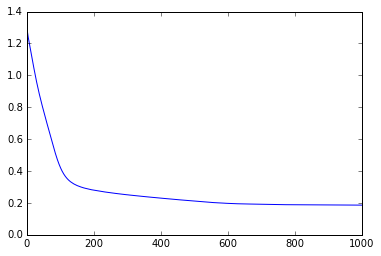

In [273]:
pd.Series(clf_grid.best_estimator_.monitors_['loss'].values).plot()

In [201]:
classifier.get_variable_value('W2').T.shape

(3, 5)

In [196]:
??classifier.get_variable_value

In [197]:
wts = np.hstack((classifier.get_variable_value('W1').T, classifier.get_variable_value('W2').T))
pd.DataFrame(wts, columns=X.columns)#.T.plot(kind='bar')

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,7.590570e-07,0.000007,7.182880e-07,2.121569e-07,-5.213333e-07,-0.000339,-0.000105,-0.000886,0.399872,-1.533133
1,-2.584211e-03,-0.000005,4.702329e-04,-1.067056e-04,3.061176e-03,0.000252,-0.000497,-0.000726,-1.532622,0.037584
2,3.535604e-07,-0.001238,-9.332093e-07,-8.378229e-07,9.369740e-06,-0.001001,-0.000774,-0.000492,-1.532028,-1.309981


In [174]:
pd.Series(np.argmax(classifier.predict(X), axis=1)).value_counts()

INFO:tensorflow:Loading model from checkpoint: /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5lww9941/model.ckpt-1000-?????-of-00001.


0    334
2    333
1    333
dtype: int64

In [175]:
yp = np.argmax(classifier.predict(X), axis=1)
pd.DataFrame({'predicted':yp, 'actual': y.values}).groupby(['predicted', 'actual']).size().unstack()

INFO:tensorflow:Loading model from checkpoint: /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmp5lww9941/model.ckpt-1000-?????-of-00001.


actual,0,1,2
predicted,,,
0,331.0,2.0,1.0
1,1.0,331.0,1.0
2,NaN,NaN,333.0
